In [1]:
from types import *
from dataloader import *
from util import *
from graphs import *
from agreement import *
from scoring import *

# There's also 'tutorial' and 'preliminary' data
data = load_data('../annotated', batch_num=1, preprocess=True)

Loading files: ['../annotated/batch_1_anton.json', '../annotated/batch_1_ayush.json', '../annotated/batch_1_kelly.json']

Found users: {'ayush', 'anton', 'kelly'}

Couldn't process grammar for substitution: ['positive', '', '', '']. Assuming 'no'...
Couldn't process positive rating for substitution: ['positive', '', '', '']. Assuming 'somewhat'...
Couldn't process grammar for substitution: ['positive', 'minor', '', '']. Assuming 'no'...
Couldn't process grammar for deletion: ['good', 'no', '']. Assuming 'no'...
Couldn't process grammar for deletion: ['good', 'no', '']. Assuming 'no'...
Couldn't process grammar for deletion: ['perfect', 'no', '']. Assuming 'no'...
Couldn't process grammar for deletion: ['good', 'no', '']. Assuming 'no'...
Couldn't process grammar for substitution: ['positive', 'a lot', '', '']. Assuming 'no'...
Couldn't process grammar for substitution: ['positive', 'somewhat', '', '']. Assuming 'no'...
Couldn't process grammar for deletion: ['good', 'no', '']. Assuming

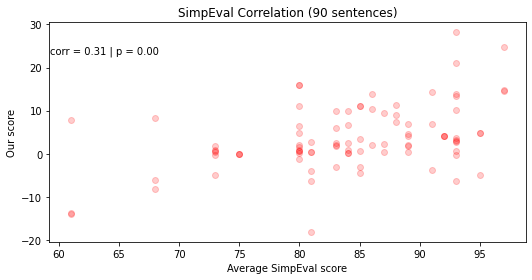

In [2]:
# Show the agreement with SimpEval
simpeval_agreement(data)

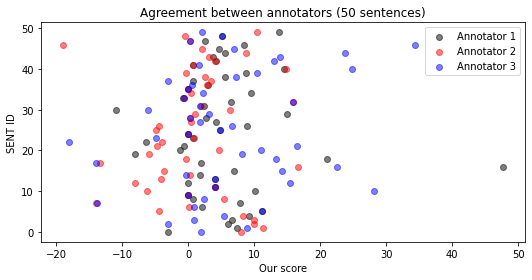

In [3]:
# Calculate the inter-annotator agreement on sentence-level scores
final = []
MAX_HIT = max([x['id'] for x in data])+1
for sent_id in range(0, MAX_HIT):
    sents = [x for x in data if x['id'] == sent_id]
    scores = [x['score'] for x in sents]
    
    # Delete this: if not all scores are present, skip this sentence
    if len(scores) != 3:
        continue
    
    final.append(scores)

# Plot the scores for each sentence
ann_mapping = {
    0: 'black',
    1: 'red',
    2: 'blue'
}
for ann in range(0, 3):
    pts = [(i, score) for i, score in enumerate([x[ann] for x in final])]
    plt.scatter([p[1] for p in pts], [p[0] for p in pts], c=ann_mapping[ann], alpha=0.5, label=f'Annotator {ann+1}')
plt.xlabel('Our score')
plt.ylabel('SENT ID')
plt.title(f'Agreement between annotators ({len(pts)} sentences)')
plt.rcParams["figure.figsize"] = (10, 5)
plt.legend()
plt.show()

In [4]:
# Calculates Rough Span Agreement Score
total_agreement = []
MAX_HIT = max([x['id'] for x in data])+1
for sent_id in range(0, MAX_HIT):
    sents = [x for x in data if x['id'] == sent_id]
    orig_tokens = get_annotations_per_token(sents, 'original')
    simp_tokens = get_annotations_per_token(sents, 'simplified')
    agg_score = 0
    for val in list(orig_tokens.values()) + list(simp_tokens.values()):
        agg_score += (list(val.values())[0] - 3)
    total_agreement.append(agg_score)
print(f"Sent with full agreement {sum([x == 0 for x in total_agreement])} / {MAX_HIT}")
hds = sorted([(i, val) for i, val in enumerate(total_agreement)], key=lambda x: x[1])
print("Highest disagreement sentence IDs")
[x[0] for x in hds][:5]

Sent with full agreement 16 / 50
Highest disagreement sentence IDs


[29, 49, 10, 23, 5]

{(0, 5): {'deletion': 3},
 (27, 32): {'substitution': 2, 'structure': 1, 'reorder': 1, 'deletion': 1},
 (33, 41): {'substitution': 3, 'structure': 1, 'reorder': 1},
 (42, 44): {'substitution': 3, 'structure': 1, 'reorder': 1},
 (45, 49): {'structure': 1, 'reorder': 1},
 (50, 53): {'structure': 1, 'reorder': 1},
 (54, 60): {'structure': 1, 'reorder': 1},
 (61, 67): {'structure': 1, 'reorder': 1},
 (68, 70): {'structure': 2, 'reorder': 2, 'substitution': 1},
 (71, 74): {'substitution': 1, 'structure': 1, 'reorder': 2},
 (75, 78): {'substitution': 1, 'structure': 1, 'reorder': 2, 'deletion': 1},
 (79, 85): {'structure': 1, 'reorder': 2}}

{(20, 24): {'structure': 2, 'reorder': 2, 'substitution': 1},
 (25, 29): {'substitution': 1, 'structure': 1, 'reorder': 2},
 (30, 35): {'structure': 1, 'reorder': 2},
 (36, 41): {'substitution': 3, 'structure': 1, 'reorder': 1},
 (42, 46): {'structure': 1, 'reorder': 1},
 (47, 50): {'structure': 1, 'reorder': 1},
 (51, 57): {'structure': 1, 'reorder': 1},
 (58, 64): {'structure': 1, 'reorder': 1}}

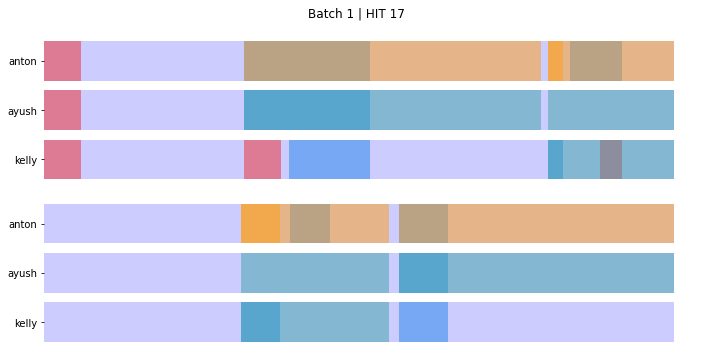

In [5]:
HID_ID = 16
sents = [x for x in data if x['id'] == HID_ID]
orig_tokens = get_annotations_per_token(sents, 'original')
simp_tokens = get_annotations_per_token(sents, 'simplified')

display(orig_tokens)
display(simp_tokens)
draw_agreement(sents)

In [6]:
# Calculates % Agreement
total_agreement = []
MAX_HIT = max([x['id'] for x in data])+1
for sent_id in range(0, MAX_HIT):
    sents = [x for x in data if x['id'] == sent_id]
    orig_tokens = get_annotations_per_token(sents, 'original')
    simp_tokens = get_annotations_per_token(sents, 'simplified')
    total_agreement += list(orig_tokens.values()) + list(simp_tokens.values())

for edit_type in edit_type_labels:
    out = {
        3: 0,
        2: 0,
        1: 0
    }
    for d in total_agreement:
        if edit_type in d.keys():
            if d[edit_type] not in out.keys():
                out[d[edit_type]] = 0
            out[d[edit_type]] += 1
    total = sum(out.values())
    # Avoid division by 0, doesn't change calculation at all
    total = 1 if total == 0 else total
    print(f'{edit_type}: {int(100*out[3]/total)} {int(100*out[2]/total)} {int(100*out[1]/total)}')

insertion: 13 16 69
deletion: 69 17 13
substitution: 27 23 49
split: 22 27 50
reorder: 8 43 49
structure: 2 24 73


In [7]:
# Some examples of high disagreement
# This isn't the correct way to calculate disagreement between the scores
# high_disagreement = [y[1] for y in sorted([(abs(x[0] - x[1]), i) for i, x in enumerate(scores) if x[0] != 0], reverse=True)][:5]
# for idx in high_disagreement:
#     example = data[idx]
#     print(f'HIT {example["id"] + 1}\nAnnotator: {example["user"]}\nSimpEval Score: {example["simpeval_scores"]}\nOur Score: {example["score"]}\nSystem: {system_name_mapping[example["system"]]}\n')

In [8]:
# Krippendorff's alpha = calculated by a token being labeled between
# annotators

<AxesSubplot:>

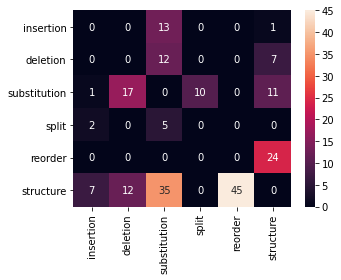

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
ann1, ann2 = [], []

for d in total_agreement:
    # Big asterisk, but we ignore 3 way disagreements
    ks = list(d.keys())
    if len(ks) == 2:
        ann1.append(ks[0])
        ann2.append(ks[1])

a = confusion_matrix(ann1, ann2, labels=edit_type_labels)
df_cm = pd.DataFrame(a, index = [i for i in edit_type_labels],
                  columns = [i for i in edit_type_labels])
plt.figure(figsize = (5,4))
sn.heatmap(df_cm, annot=True)

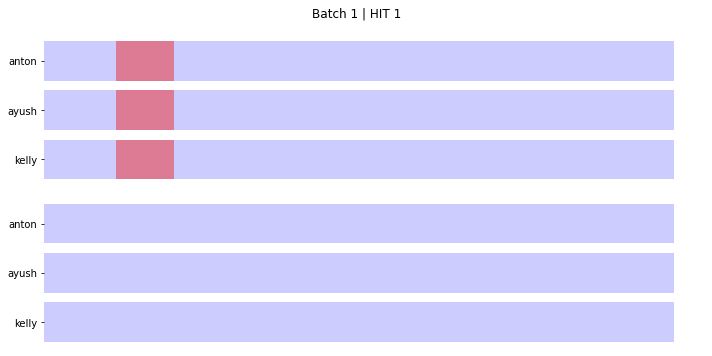

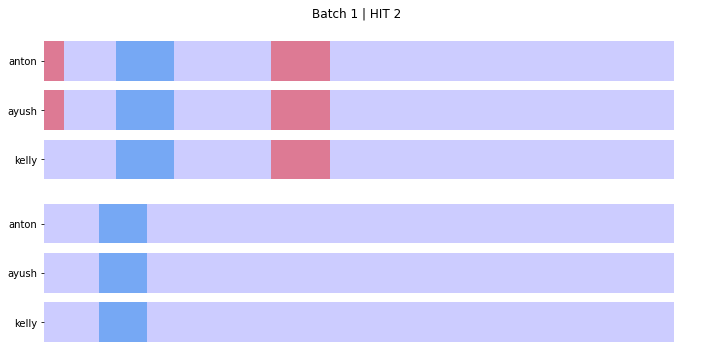

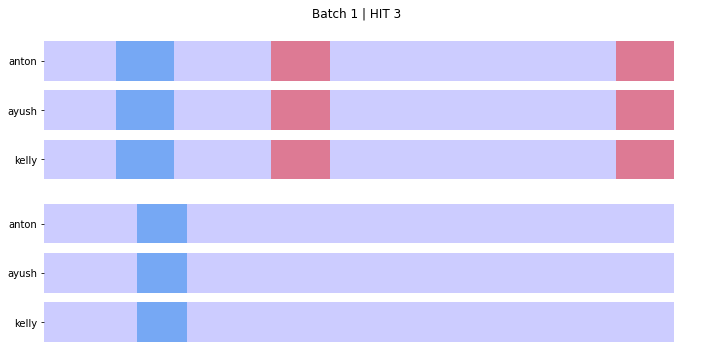

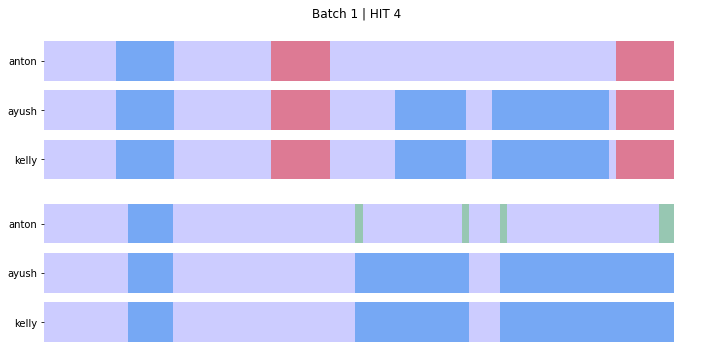

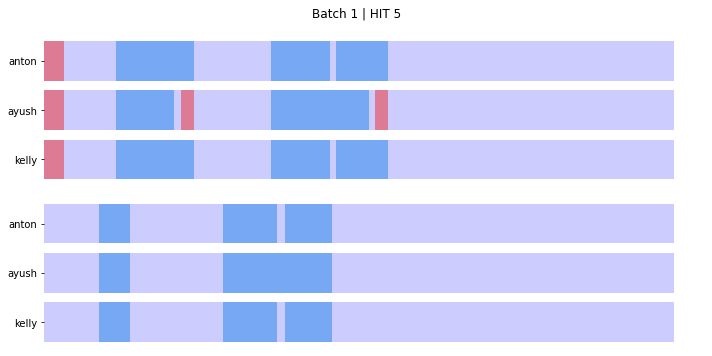

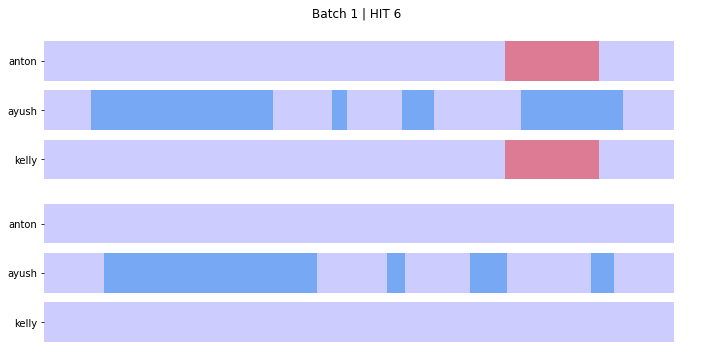

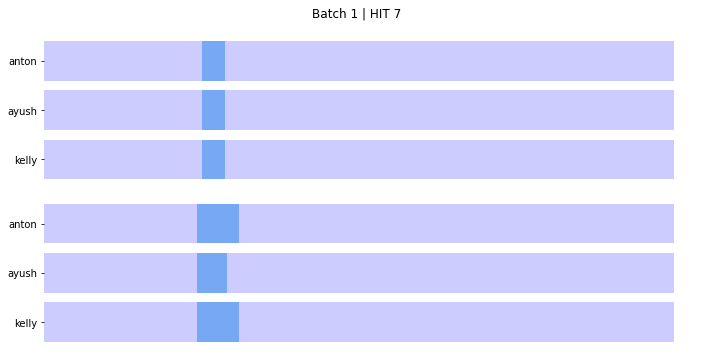

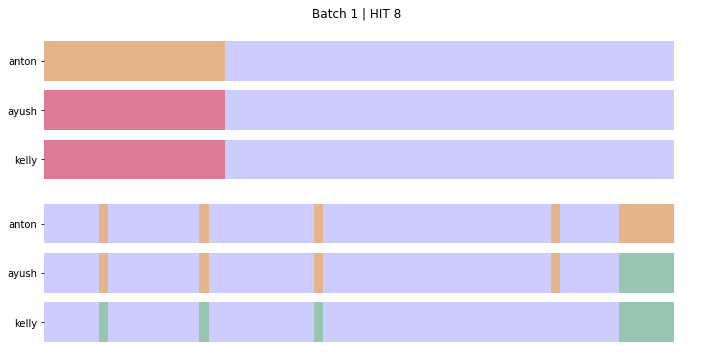

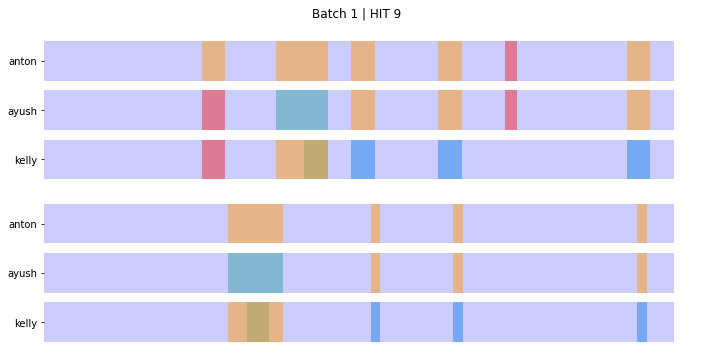

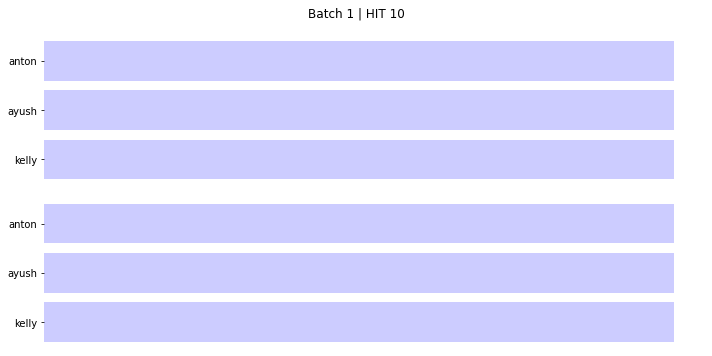

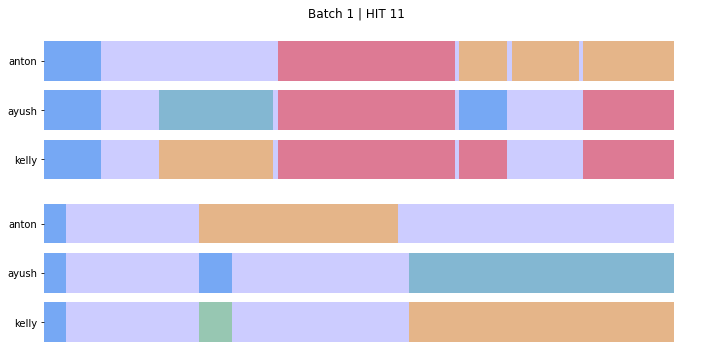

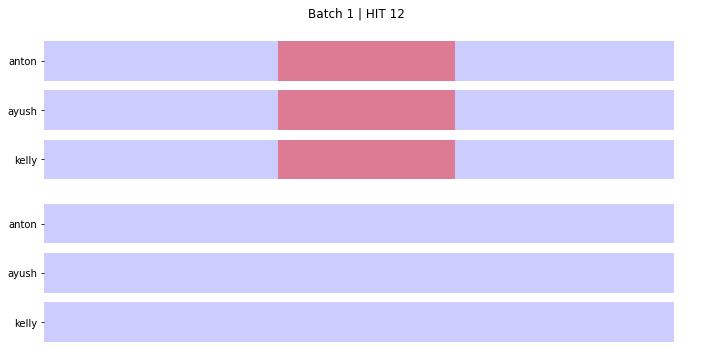

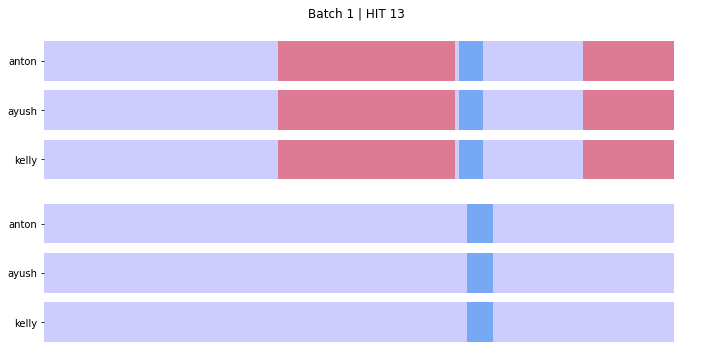

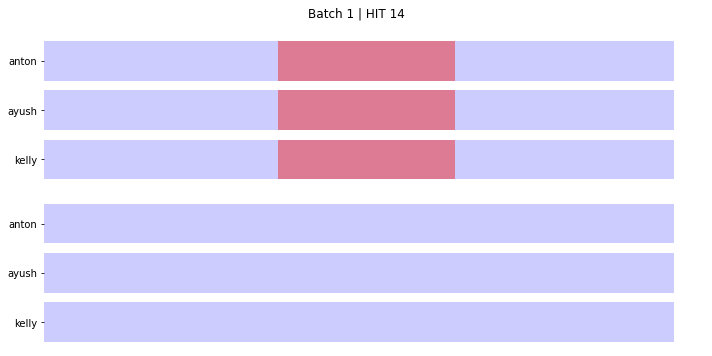

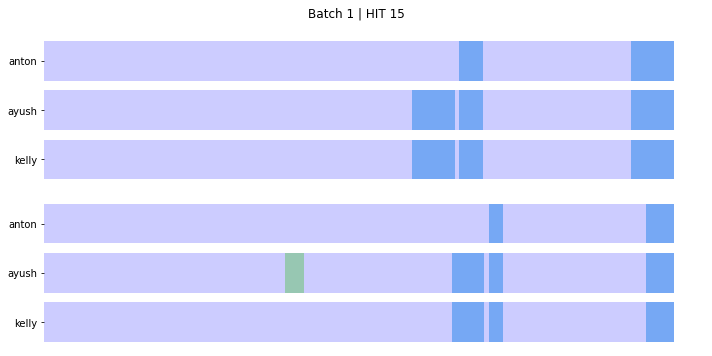

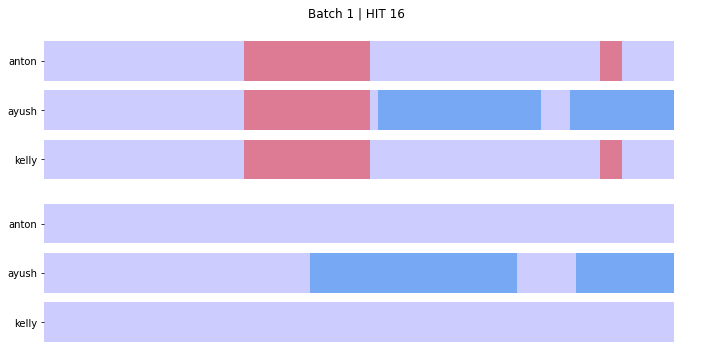

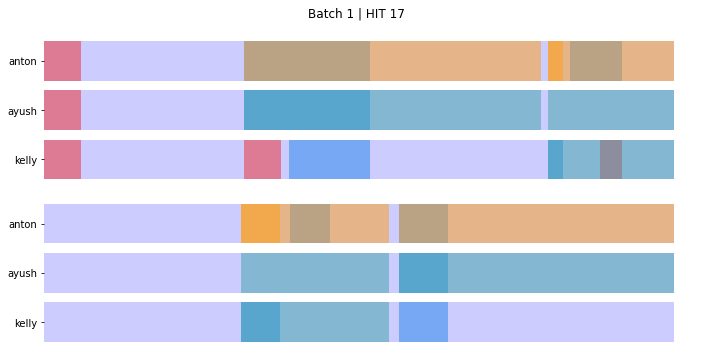

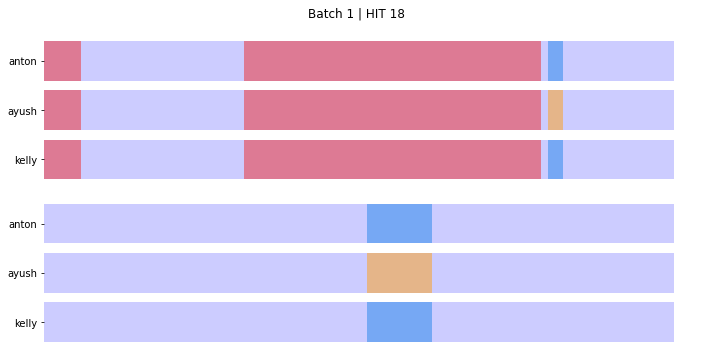

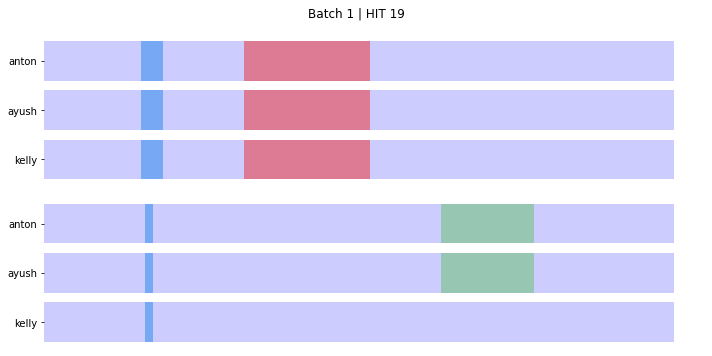

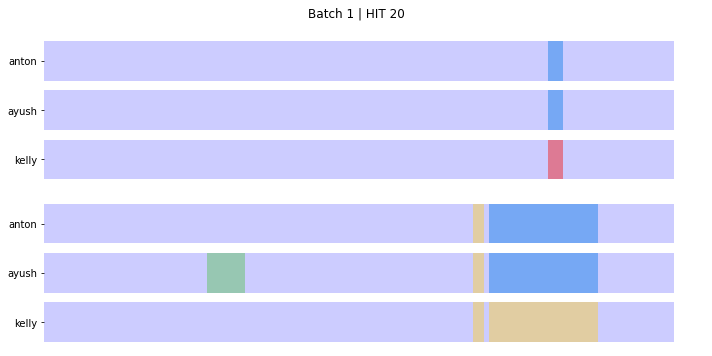

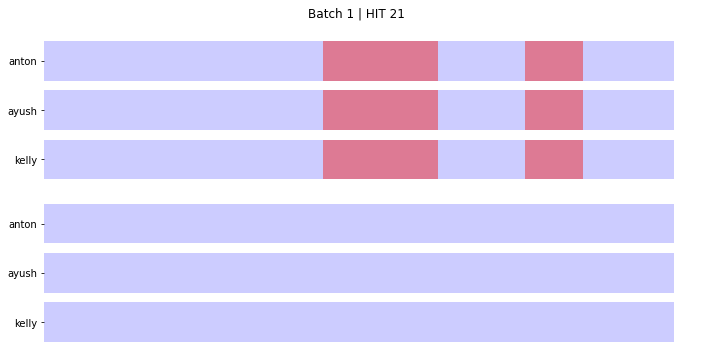

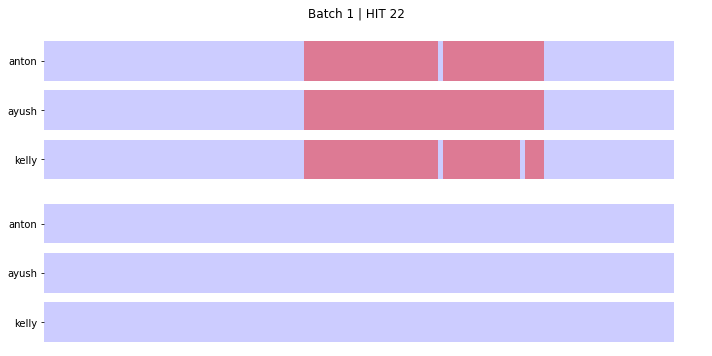

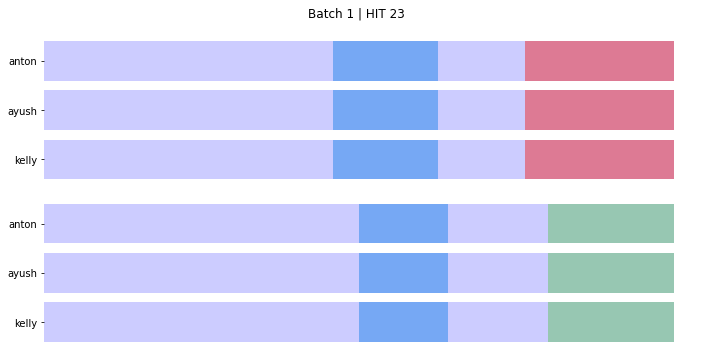

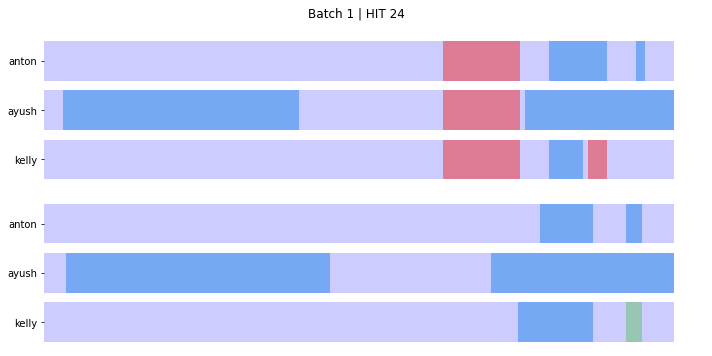

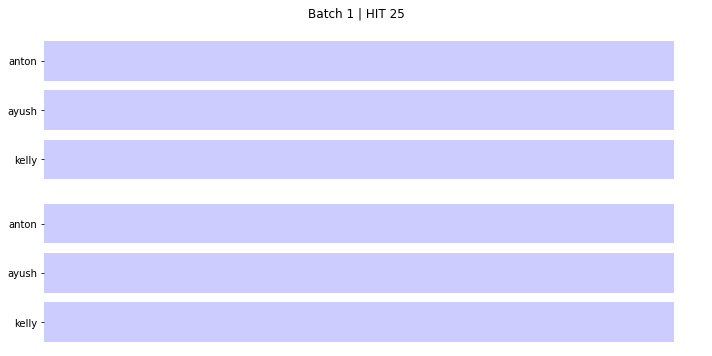

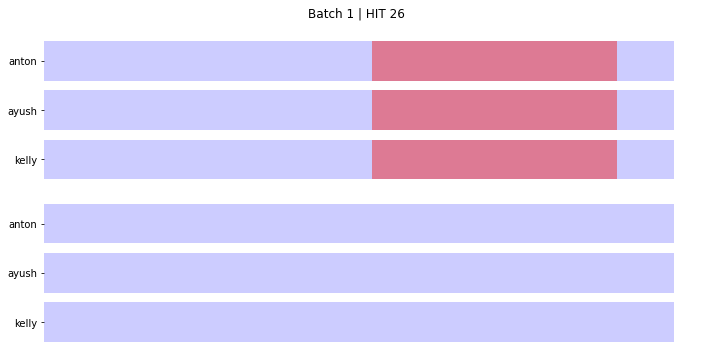

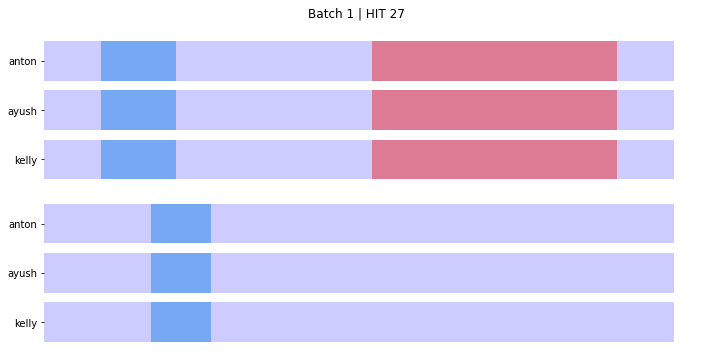

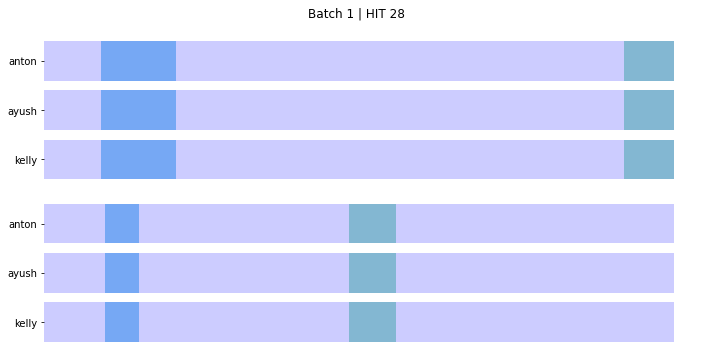

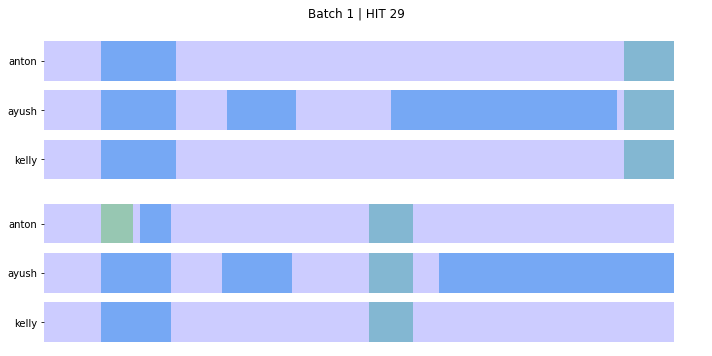

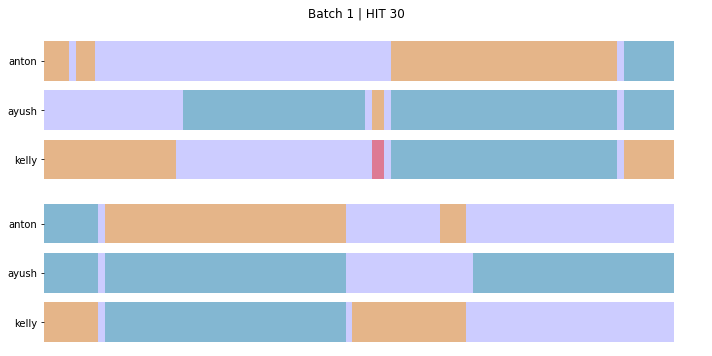

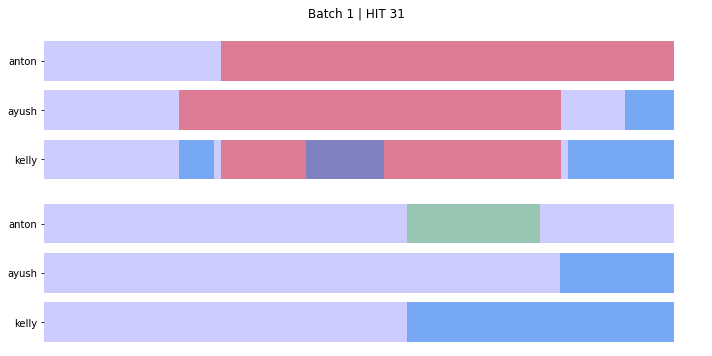

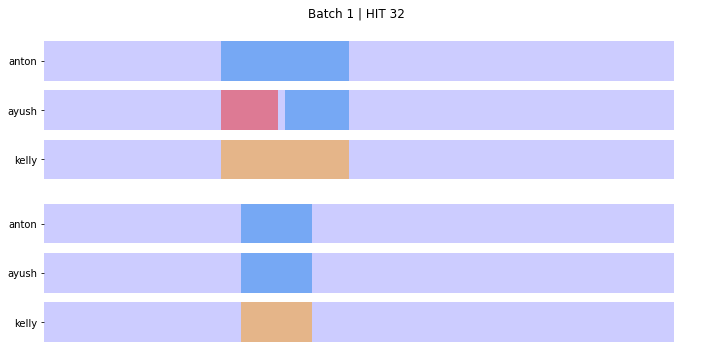

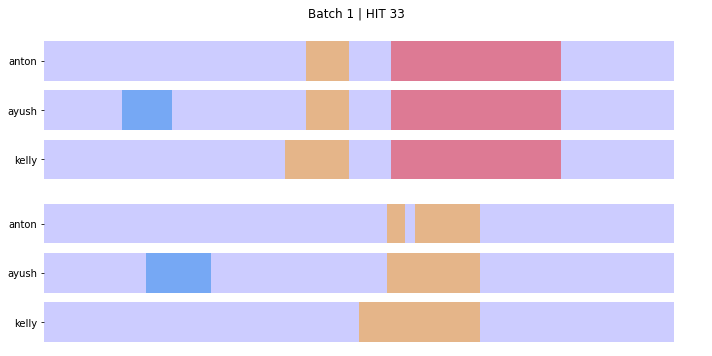

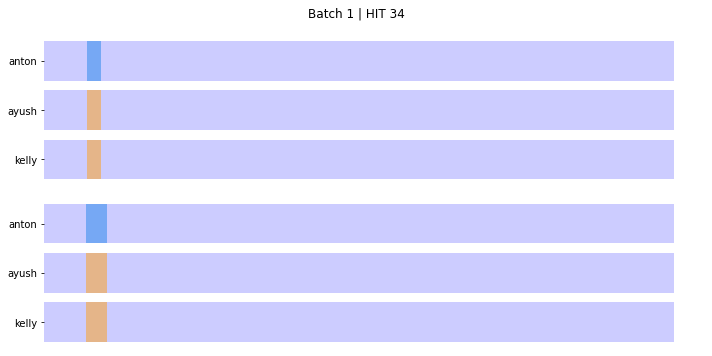

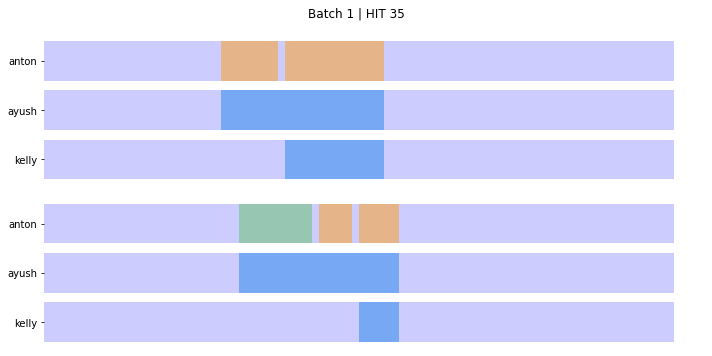

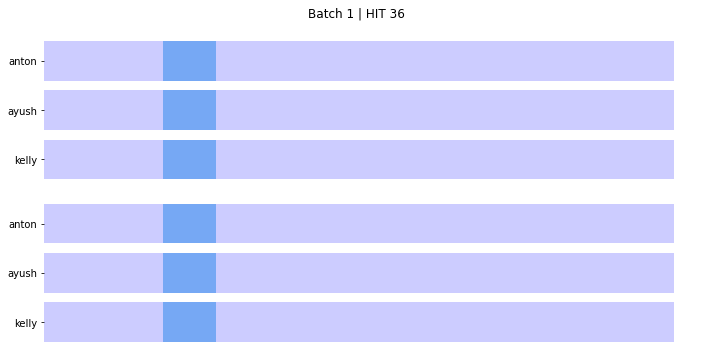

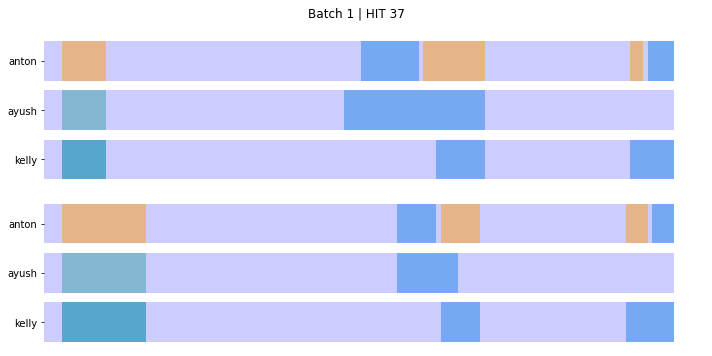

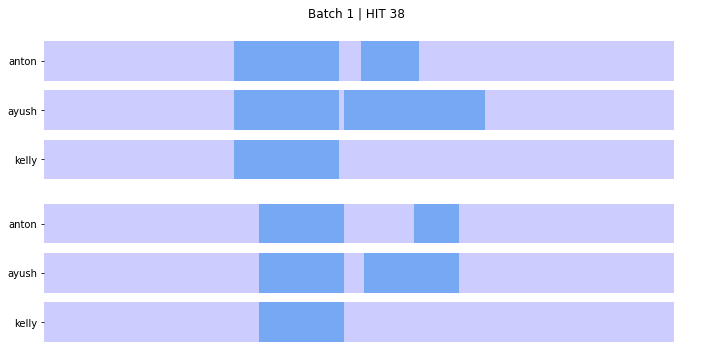

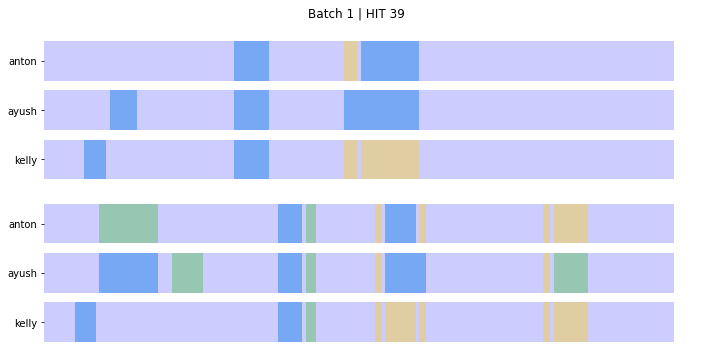

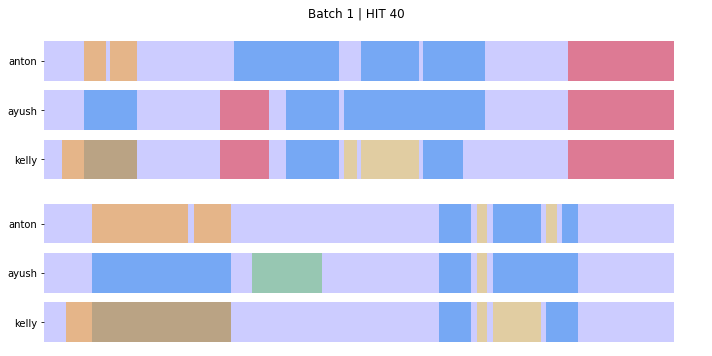

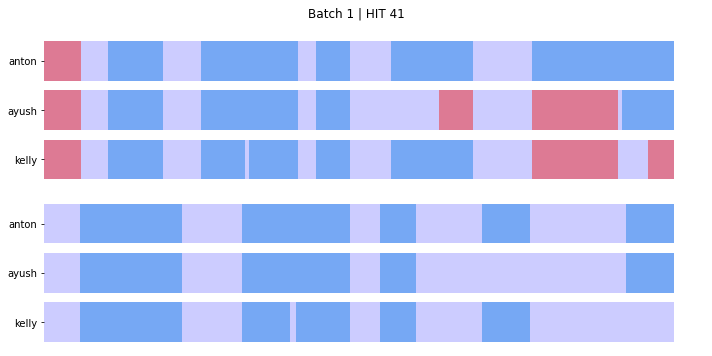

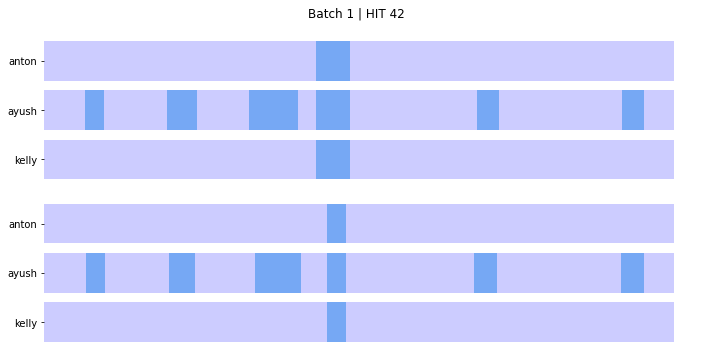

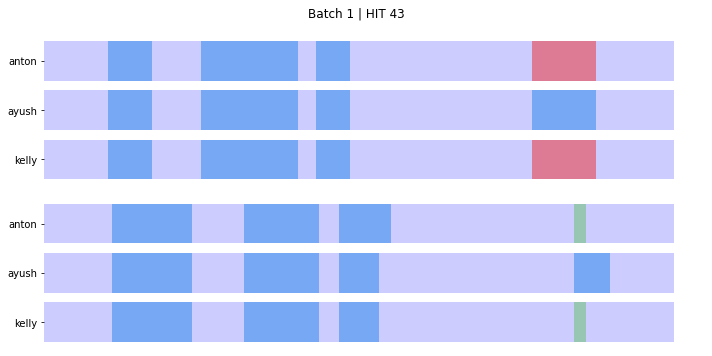

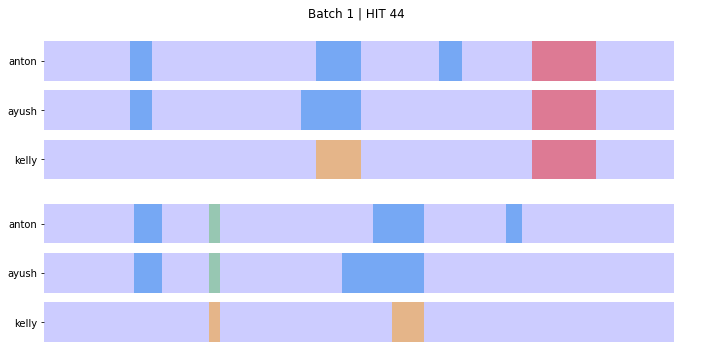

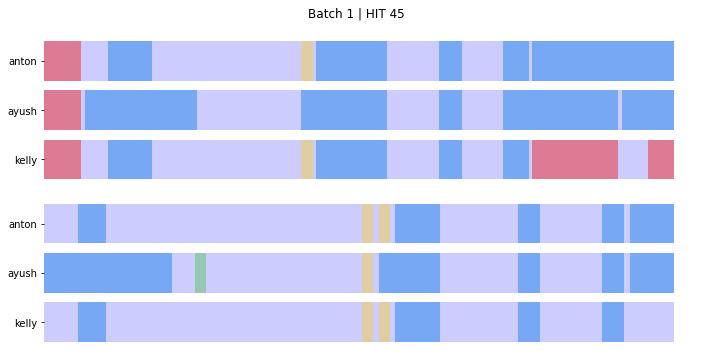

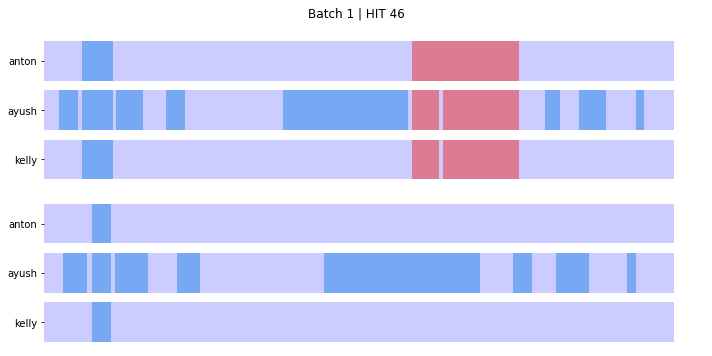

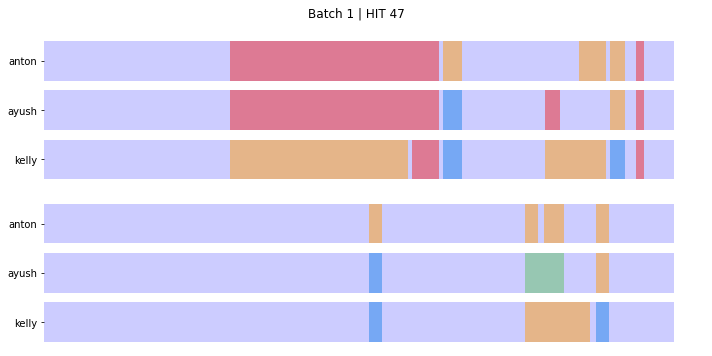

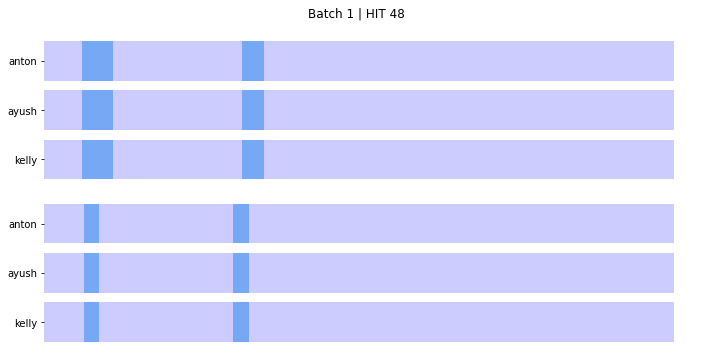

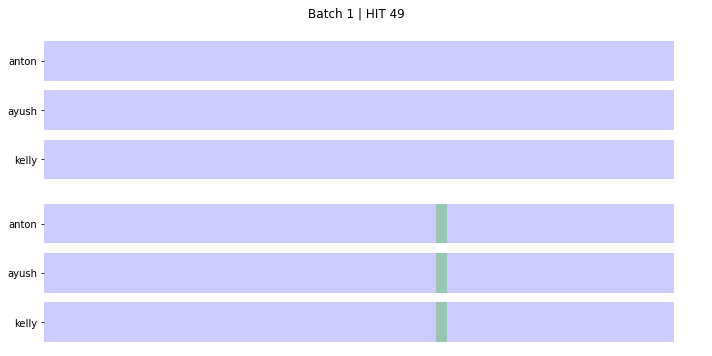

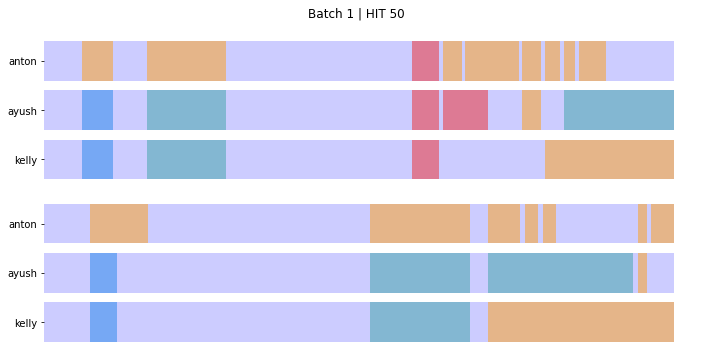

In [10]:
# Display the agreeement on all sentences
MAX_HIT = max([x['id'] for x in data])+1
for sent_id in range(0, MAX_HIT):
    sents = [x for x in data if x['id'] == sent_id]
    draw_agreement(sents)